# Solving the SWE using NN + FNO

In [472]:
# Load packages
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from scipy.fftpack import fft, ifft
import scipy.io

import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.optim as optim


## Load data

In [473]:
# Load a single .mat file
filename = 'dataFNO/data_sigma_no1.mat'
mat_data = scipy.io.loadmat(filename)

# Print the keys of the loaded data
print(mat_data.keys())

# Extract the necessary data (x and h_all) from the loaded data
x = mat_data['x'].flatten()
h_all = mat_data['h_all'][1:,:]
t = mat_data['time_all'].flatten()

h_all.shape
sigma = mat_data['sigma'][0,0]

print('sigma:', sigma)


dict_keys(['__header__', '__version__', '__globals__', 'h0', 'h_all', 'sigma', 'time_all', 'u_all', 'x'])
sigma: 0.1


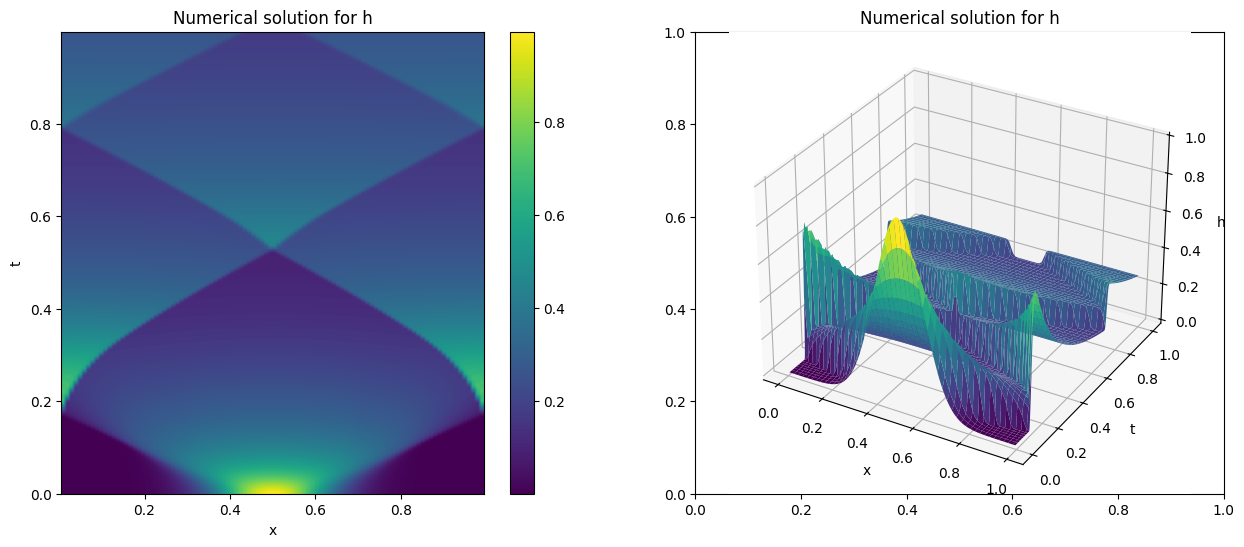

In [474]:
save = 0

# Plot the data in x,t space
fig, ax = plt.subplots(1, 2, figsize=(15, 6))
img = ax[0].imshow(h_all, extent=[x[0], x[-1], t[-1], t[0]], aspect='auto')
plt.colorbar(img, ax=ax[0])
ax[0].set_title('Numerical solution for h')
ax[0].set_xlabel('x')
ax[0].set_ylabel('t')
ax[0].invert_yaxis()

# Plot in 3D
X, T = np.meshgrid(x, t)
ax[1] = fig.add_subplot(122, projection='3d')
ax[1].plot_surface(X, T, h_all, cmap='viridis')
ax[1].set_title('Numerical solution for h')
ax[1].set_xlabel('x')
ax[1].set_ylabel('t')
ax[1].set_zlabel('h')

if save:
    plt.savefig('plots/NN_initial.pdf', format='pdf')

plt.show()


In [475]:
# Define percentage of data to use for training
P = 0.8

# Split the data into training and testing sets
n_train = int(P * len(t))

h_train = h_all[:n_train, :]
h_test = h_all[n_train:, :]

# Define the input and output data for the training sets
X_train = h_train[:-1, :]
Y_train = h_train[1:, :]

X_test = h_test[:-1, :]
Y_test = h_test[1:, :]

## Solve the SWE using NN

### (i) FNN

In [476]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


In [477]:
in_features = 100
hidden1 = 128
hidden2 = 128
hidden3 = 64
out_features = 100

model = nn.Sequential(
    nn.Linear(in_features, hidden1),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(hidden1, hidden2),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(hidden2, hidden3),
    nn.Linear(hidden3, out_features),
    nn.Sigmoid()
)

print(model)

Sequential(
  (0): Linear(in_features=100, out_features=128, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.2, inplace=False)
  (3): Linear(in_features=128, out_features=128, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.2, inplace=False)
  (6): Linear(in_features=128, out_features=64, bias=True)
  (7): Linear(in_features=64, out_features=100, bias=True)
  (8): Sigmoid()
)


In [478]:
X = h_train

# Assuming X has shape (243, 100) (time steps, spatial steps)
input_data = X[:-1]  # Shape: (242, 100)
output_data = X[1:]  # Shape: (242, 100)

# Create a DataLoader for batches
dataset = torch.utils.data.TensorDataset(torch.tensor(input_data, dtype=torch.float32),
                                         torch.tensor(output_data, dtype=torch.float32))
data_loader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)


In [479]:
# Loss and optimizer
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

losses = []

# Training loop
n_epochs = 500

for epoch in range(n_epochs):
    for batch_X, batch_y in data_loader:
        # Forward pass
        predictions = model(batch_X)
        loss = loss_fn(predictions, batch_y)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Average epoch loss
    loss /= len(dataset)
    losses.append(loss.item())

    if epoch % 10 == 9:
        print(f"Epoch {epoch+1}/{n_epochs}, Loss: {loss.item():.7f}")


Epoch 10/500, Loss: 0.0000260
Epoch 20/500, Loss: 0.0000193
Epoch 30/500, Loss: 0.0000157
Epoch 40/500, Loss: 0.0000102
Epoch 50/500, Loss: 0.0000123
Epoch 60/500, Loss: 0.0000109
Epoch 70/500, Loss: 0.0000112
Epoch 80/500, Loss: 0.0000095
Epoch 90/500, Loss: 0.0000084
Epoch 100/500, Loss: 0.0000083
Epoch 110/500, Loss: 0.0000068
Epoch 120/500, Loss: 0.0000071
Epoch 130/500, Loss: 0.0000051
Epoch 140/500, Loss: 0.0000045
Epoch 150/500, Loss: 0.0000055
Epoch 160/500, Loss: 0.0000054
Epoch 170/500, Loss: 0.0000048
Epoch 180/500, Loss: 0.0000047
Epoch 190/500, Loss: 0.0000042
Epoch 200/500, Loss: 0.0000049
Epoch 210/500, Loss: 0.0000044
Epoch 220/500, Loss: 0.0000043
Epoch 230/500, Loss: 0.0000044
Epoch 240/500, Loss: 0.0000046
Epoch 250/500, Loss: 0.0000032
Epoch 260/500, Loss: 0.0000032
Epoch 270/500, Loss: 0.0000049
Epoch 280/500, Loss: 0.0000039
Epoch 290/500, Loss: 0.0000034
Epoch 300/500, Loss: 0.0000035
Epoch 310/500, Loss: 0.0000034
Epoch 320/500, Loss: 0.0000031
Epoch 330/500, Lo

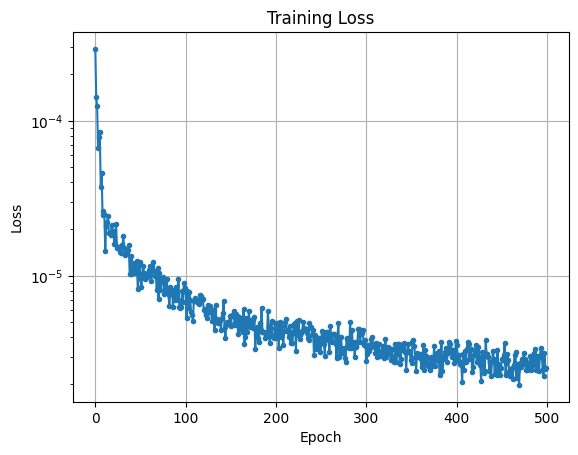

In [480]:
# Plot loss
plt.semilogy(losses, '.-', label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.grid()
plt.show()


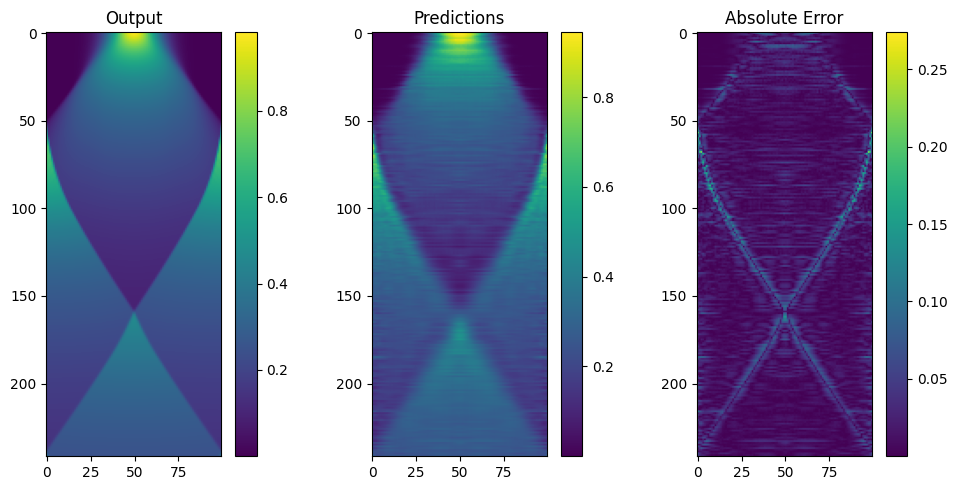

In [481]:
# make probability predictions with the model
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
predictions = model(X_train_tensor)

# Plot the input, output, and predictions
plt.figure(figsize=(10, 5))

plt.subplot(1, 3, 1)
plt.imshow(Y_train)
plt.colorbar()
plt.title('Output')

plt.subplot(1, 3, 2)
plt.imshow(predictions.detach().numpy())
plt.colorbar()
plt.title('Predictions')

plt.subplot(1, 3, 3)
plt.imshow(np.abs(Y_train - predictions.detach().numpy()))
plt.colorbar()
plt.title('Absolute Error')

plt.tight_layout()

plt.show()


### (ii) RNN Flowmap

In [496]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


In [497]:
# Define model
class RNNFlowmap(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=4, dropout=0.2):
        super(RNNFlowmap, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers=num_layers, dropout=dropout, batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size)
        )

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])  # Use the last hidden state for prediction
        return out
    
input_size = 100
hidden_size = 128
output_size = 100

# Instantiate the model
model = RNNFlowmap(input_size, hidden_size, output_size)
print(model)


RNNFlowmap(
  (rnn): RNN(100, 128, num_layers=4, batch_first=True, dropout=0.2)
  (fc): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=100, bias=True)
  )
)


In [498]:
X = h_train.copy()
timesteps, spatial_steps = X.shape

# Define sequence length
sequence_length = 10
num_sequences = timesteps - sequence_length

batch_size = 32

# Create input-output pairs
X_input = []
X_output = []

for i in range(num_sequences):
    X_input.append(X[i:i+sequence_length])    # Sequence of length 5
    X_output.append(X[i+sequence_length])    # Next time step

X_input = np.array(X_input)  # Shape: (num_sequences, sequence_length, spatial_steps)
X_output = np.array(X_output)  # Shape: (num_sequences, spatial_steps)

X_input_tensor = torch.tensor(X_input, dtype=torch.float32)
X_output_tensor = torch.tensor(X_output, dtype=torch.float32)

# Create a DataLoader
batch_size = 32
dataset = torch.utils.data.TensorDataset(X_input_tensor, X_output_tensor)
data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)


In [499]:
# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

losses = []

# Training loop
n_epochs = 100
for epoch in range(n_epochs):
    model.train()  # Set model to training mode
    epoch_loss = 0.0  # Track loss for the epoch
    
    for batch_X, batch_y in data_loader:
        # Forward pass
        predictions = model(batch_X)  # Shape: (batch_size, output_size)
        loss = loss_fn(predictions, batch_y)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Accumulate loss
        epoch_loss += loss.item() * batch_X.size(0)  # Multiply by batch size for total loss

    # Average epoch loss
    epoch_loss /= len(dataset)
    losses.append(epoch_loss)
    if epoch % 10 == 9:
        print(f"Epoch {epoch + 1}/{n_epochs}, Loss: {epoch_loss:.6f}")

Epoch 10/100, Loss: 0.003109
Epoch 20/100, Loss: 0.001728
Epoch 30/100, Loss: 0.001345
Epoch 40/100, Loss: 0.001072
Epoch 50/100, Loss: 0.000865
Epoch 60/100, Loss: 0.000711
Epoch 70/100, Loss: 0.000706
Epoch 80/100, Loss: 0.000622
Epoch 90/100, Loss: 0.000591
Epoch 100/100, Loss: 0.000546


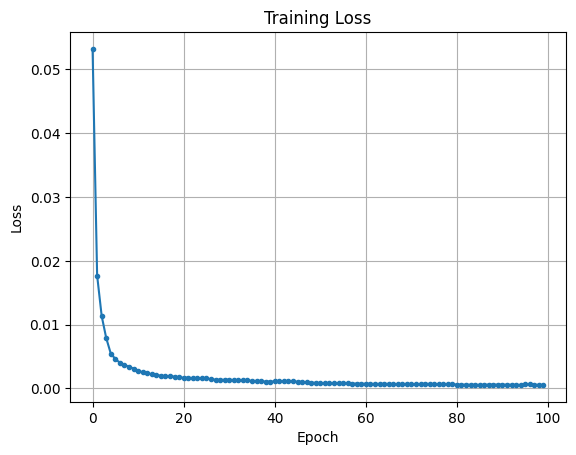

In [500]:
# Plot loss
plt.plot(losses, '.-', label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.grid()
plt.show()

Test Loss: 0.000505


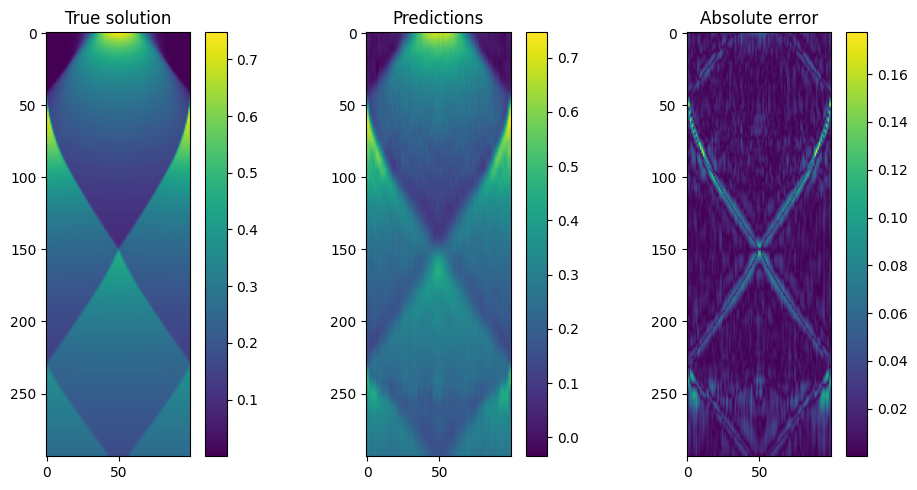

In [501]:
# Predictions for all data
X_all = h_all.copy()
timesteps, spatial_steps = X_all.shape

num_sequences = timesteps - sequence_length

X_input = []
X_output = []

for i in range(num_sequences):
    X_input.append(X_all[i:i+sequence_length])    # Sequence of length sequence_length
    X_output.append(X_all[i+sequence_length])    # Next time step

X_input = np.array(X_input)  # Shape: (num_sequences, sequence_length, spatial_steps)
X_output = np.array(X_output)  # Shape: (num_sequences, spatial_steps)

X_input_tensor = torch.tensor(X_input, dtype=torch.float32)
X_output_tensor = torch.tensor(X_output, dtype=torch.float32)

# Predictions
model.eval()  # Set to evaluation mode
with torch.no_grad():  # Disable gradient computation
    predictions = model(X_input_tensor)  # Full dataset
    test_loss = loss_fn(predictions, X_output_tensor)
    print(f"Test Loss: {test_loss.item():.6f}")

# Plot the output, predictions and absolute error
plt.figure(figsize=(10, 5))

plt.subplot(1, 3, 1)
plt.imshow(X_output)
plt.colorbar()
plt.title('True solution')

plt.subplot(1, 3, 2)
plt.imshow(predictions.numpy())
plt.colorbar()
plt.title('Predictions')

plt.subplot(1, 3, 3)
plt.imshow(np.abs(X_output - predictions.numpy()))
plt.colorbar()
plt.title('Absolute error')

plt.tight_layout()

plt.show()


In [520]:
X, T = np.meshgrid(x, t[sequence_length:])

print(X.shape)

print(X_output.shape)

(294, 100)
(294, 100)


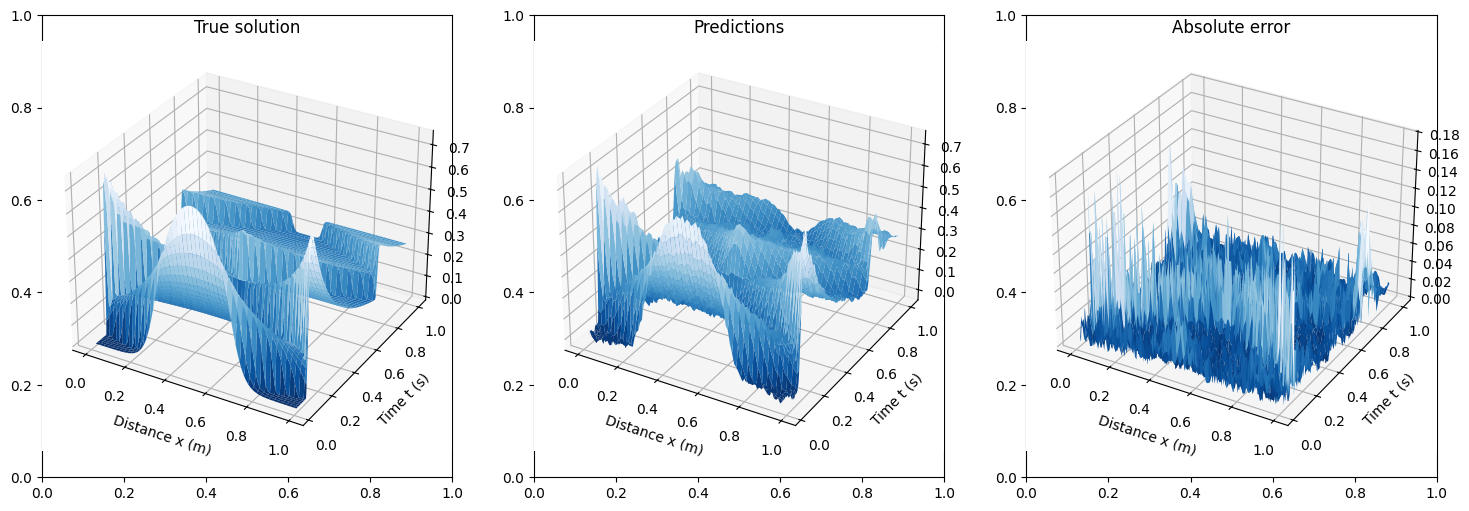

In [530]:
cmap = 'Blues_r'

X, T = np.meshgrid(x, t[sequence_length:])

# Plot the output, predictions and absolute error
fig, ax = plt.subplots(1, 3, figsize=(18, 6))

# Plot in 3d
ax[0] = fig.add_subplot(131, projection='3d')
ax[0].plot_surface(X, T, X_output, cmap=cmap)
ax[0].set_title('True solution')
ax[0].set_xlabel('Distance x (m)')
ax[0].set_ylabel('Time t (s)')

ax[1] = fig.add_subplot(132, projection='3d')
ax[1].plot_surface(X, T, predictions.numpy(), cmap=cmap)
ax[1].set_title('Predictions')
ax[1].set_xlabel('Distance x (m)')
ax[1].set_ylabel('Time t (s)')

ax[2] = fig.add_subplot(133, projection='3d')
ax[2].plot_surface(X, T, np.abs(X_output - predictions.numpy()), cmap=cmap)
ax[2].set_title('Absolute error')
ax[2].set_xlabel('Distance x (m)')
ax[2].set_ylabel('Time t (s)')

plt.show()

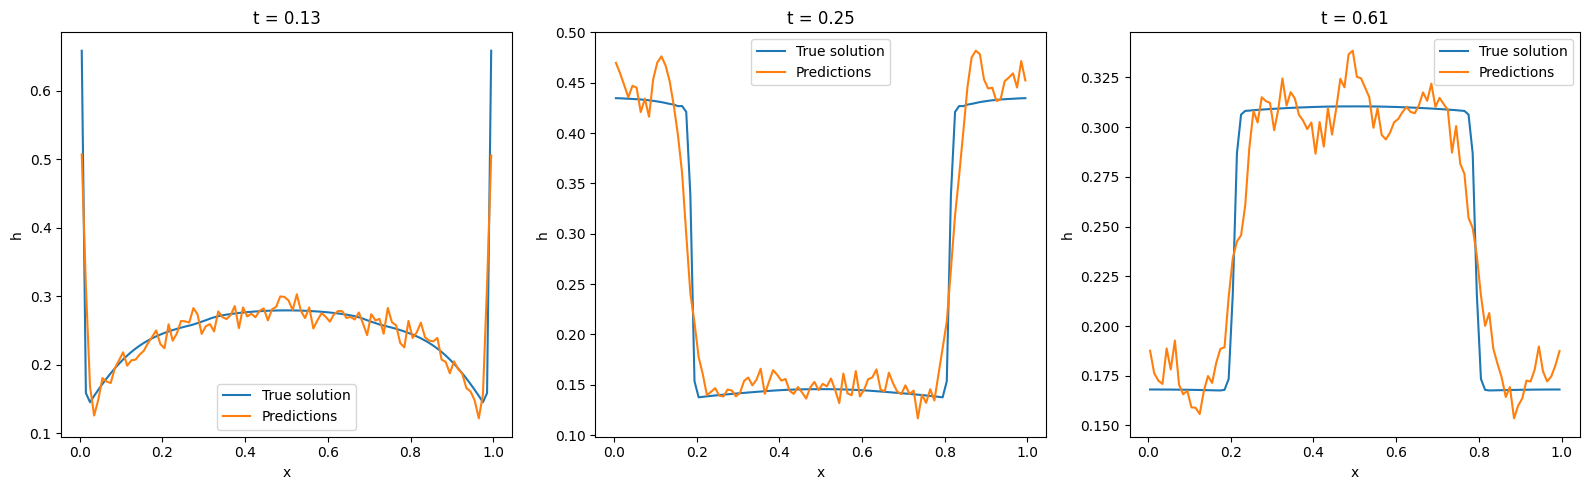

In [537]:
# Plot for some given time steps
indices = [50, 100, 200]

# Create a figure with subplots
fig, axes = plt.subplots(nrows=1, ncols=len(indices), figsize=(16, 5))

for i, idx in enumerate(indices):
    ax = axes[i]
    ax.plot(x, X_output[idx], label='True solution')
    ax.plot(x, predictions[idx].numpy(), label='Predictions')
    ax.set_title(f"t = {t[idx + sequence_length]:.2f}")
    ax.set_xlabel('x')
    ax.set_ylabel('h')
    ax.legend()

plt.tight_layout()
plt.show()


### (iii) LSTM (Long short-term memory)

In [488]:
# LSTM class neural network
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=4, dropout=0.2):
        super(LSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers, dropout=dropout, batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size)
        )

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

input_size = 100
hidden_size = 128
output_size = 100

# Define model
model = LSTM(input_size, hidden_size, output_size)
print(model)

LSTM(
  (lstm): LSTM(100, 128, num_layers=4, batch_first=True, dropout=0.2)
  (fc): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=100, bias=True)
  )
)


In [489]:
# Define sequence length
sequence_length = 5
num_sequences = 243 - sequence_length
X = h_train.copy()
batch_size = 32

# Create input-output pairs
X_input = []
X_output = []

for i in range(num_sequences):
    X_input.append(X[i:i+sequence_length])    # Sequence of length 5
    X_output.append(X[i+sequence_length])    # Next time step

X_input = np.array(X_input)  # Shape: (num_sequences, sequence_length, 100)
X_output = np.array(X_output)  # Shape: (num_sequences, 100)

X_input_tensor = torch.tensor(X_input, dtype=torch.float32)
X_output_tensor = torch.tensor(X_output, dtype=torch.float32)

# Create a DataLoader
batch_size = 32
dataset = torch.utils.data.TensorDataset(X_input_tensor, X_output_tensor)

data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)


In [490]:
# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

losses = []

# Training loop
n_epochs = 10
for epoch in range(n_epochs):
    model.train()  # Set model to training mode
    epoch_loss = 0.0  # Track loss for the epoch
    
    for batch_X, batch_y in data_loader:
        # Forward pass
        predictions = model(batch_X)  # Shape: (batch_size, output_size)
        loss = loss_fn(predictions, batch_y)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Accumulate loss
        epoch_loss += loss.item() * batch_X.size(0)  # Multiply by batch size for total loss

    # Average epoch loss
    epoch_loss /= len(dataset)
    losses.append(epoch_loss)
    if epoch % 10 == 9:
        print(f"Epoch {epoch + 1}/{n_epochs}, Loss: {epoch_loss:.6f}")

Epoch 10/10, Loss: 0.008448


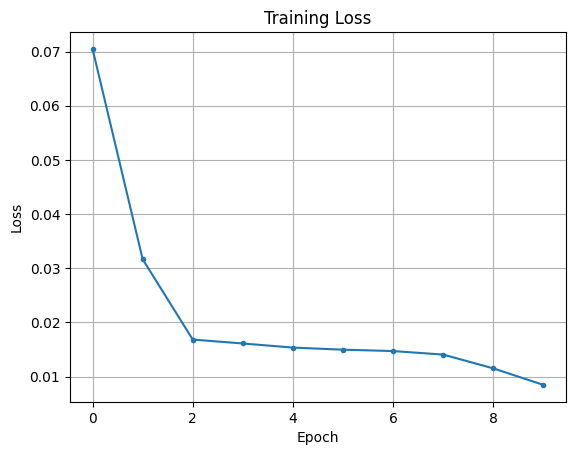

In [491]:
# Plot loss
plt.plot(losses, '.-', label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.grid()
plt.show()

Test Loss: 0.006726


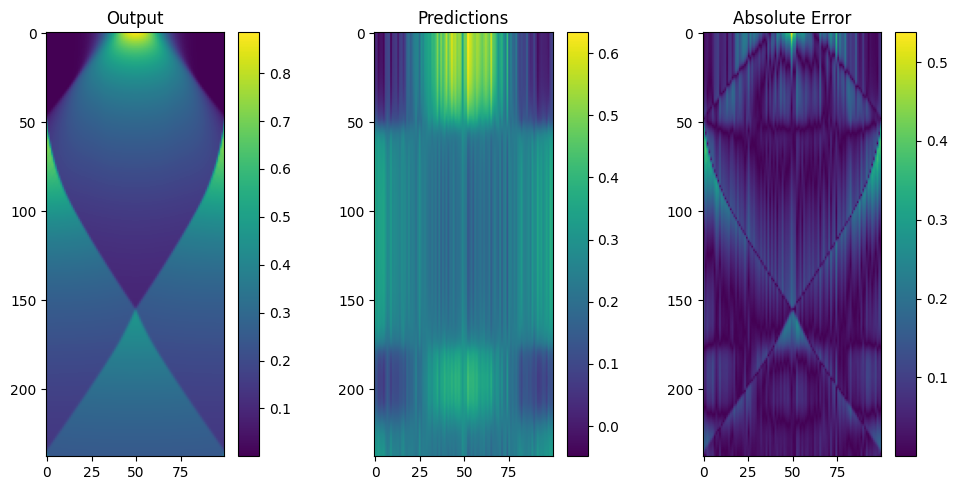

In [492]:
model.eval()  # Set to evaluation mode
with torch.no_grad():  # Disable gradient computation
    predictions = model(X_input_tensor)  # Full dataset
    test_loss = loss_fn(predictions, X_output_tensor)
    print(f"Test Loss: {test_loss.item():.6f}")

# Plot the input, output, and predictions
plt.figure(figsize=(10, 5))

plt.subplot(1, 3, 1)
plt.imshow(X_output)
plt.colorbar()
plt.title('Output')

plt.subplot(1, 3, 2)
plt.imshow(predictions.numpy())
plt.colorbar()
plt.title('Predictions')

plt.subplot(1, 3, 3)
plt.imshow(np.abs(X_output - predictions.numpy()))
plt.colorbar()
plt.title('Absolute Error')

plt.tight_layout()
plt.show()
